[I 2024-10-16 23:36:47,128] A new study created in memory with name: no-name-d145d0b3-5ae0-4edf-84f3-4a1319cb3989
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_50267/2180810737.py:73: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-16 23:36:52,576] Trial 0 finished with value: 0.9152542352676392 and parameters: {'n_conv_layers': 4, 'filters_1': 167, 'kernel_1': 3, 'filters_2': 249, 'kernel_2': 3

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best Accuracy: 0.9831
ROC AUC: 0.9966
PR AUC: 0.9967

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.98        29

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59


Best Hyperparameters:
{'n_conv_layers': 2, 'filters_1': 123, 'kernel_1': 5, 'filters_2': 174, 'kernel_2': 5, 'n_dense_layers': 1, 'dense_units_1': 236, 'dropout_1': 0.2442001076472947, 'learning_rate': 3.789679799493379e-05, 'batch_size': 16}


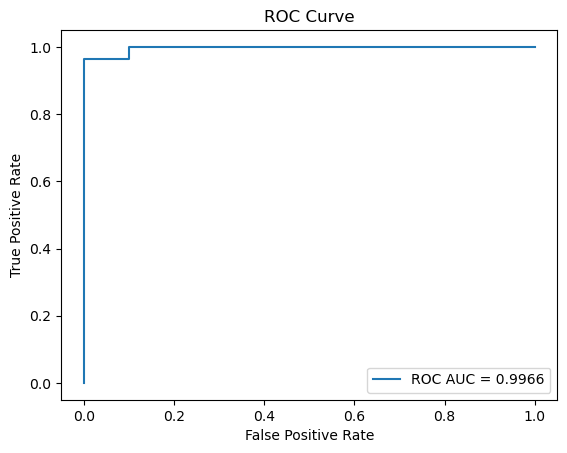

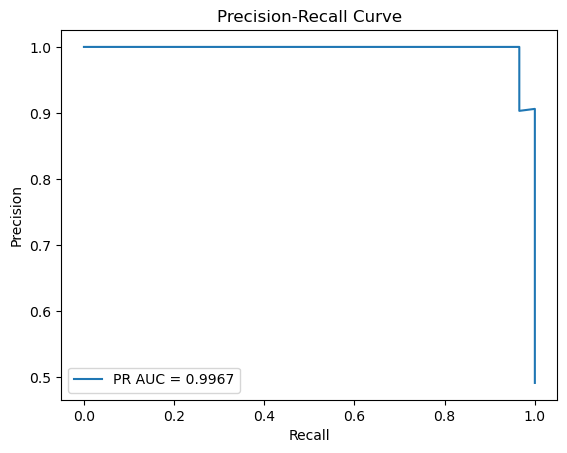

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Apply SMOTE to deal with class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data for CNN
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Optuna optimization with more focus on advanced tuning
def create_model(trial):
    model = Sequential()
    
    # Number of convolutional layers
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 4)
    
    # First Conv Layer
    model.add(Conv1D(filters=trial.suggest_int('filters_1', 32, 256),
                     kernel_size=trial.suggest_int('kernel_1', 2, 5),
                     activation='relu',
                     input_shape=(X_train_scaled.shape[1], 1)))
    model.add(BatchNormalization())  # Add batch normalization for faster convergence
    
    # Additional Conv1D layers
    for i in range(1, n_conv_layers):
        model.add(Conv1D(filters=trial.suggest_int(f'filters_{i+1}', 32, 256),
                         kernel_size=trial.suggest_int(f'kernel_{i+1}', 2, 5),
                         activation='relu'))
        model.add(BatchNormalization())  # Batch normalization for deeper layers
    
    # Global Average Pooling instead of MaxPooling
    model.add(GlobalAveragePooling1D())
    
    # Add Dense layers with Dropout
    n_dense_layers = trial.suggest_int('n_dense_layers', 1, 3)
    for i in range(n_dense_layers):
        model.add(Dense(trial.suggest_int(f'dense_units_{i+1}', 64, 512), activation='relu'))
        model.add(Dropout(trial.suggest_float(f'dropout_{i+1}', 0.2, 0.5)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with Adam optimizer
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Optuna objective function
def objective(trial):
    model = create_model(trial)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    
    # Train model with validation split
    history = model.fit(X_train_reshaped, y_train,
                        epochs=200,
                        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=0)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
    return accuracy

# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

# Get the best model
best_model = create_model(study.best_trial)
best_model.fit(X_train_reshaped, y_train,
               epochs=200,
               batch_size=study.best_params['batch_size'],
               validation_split=0.2,
               callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
               verbose=0)

# Evaluate the best model
y_pred = (best_model.predict(X_test_reshaped) > 0.5).astype(int)
y_pred_proba = best_model.predict(X_test_reshaped)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

print(f"Best Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nBest Hyperparameters:")
print(study.best_params)

### Plotting ROC and Precision-Recall Curves ###

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


[I 2024-10-17 00:00:43,916] A new study created in memory with name: no-name-3059dc54-5d37-447e-b58c-bd832edfada3
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_50267/546494557.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/si


AdaBoost Best Hyperparameters: {'n_estimators': 497, 'learning_rate': 0.8517104876075329}
AdaBoost Best Accuracy: 0.9558


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       147
           1       0.98      0.93      0.95       147

    accuracy                           0.96       294
   macro avg       0.96      0.96      0.96       294
weighted avg       0.96      0.96      0.96       294

AdaBoost ROC AUC: 0.9778
AdaBoost PR AUC: 0.9783


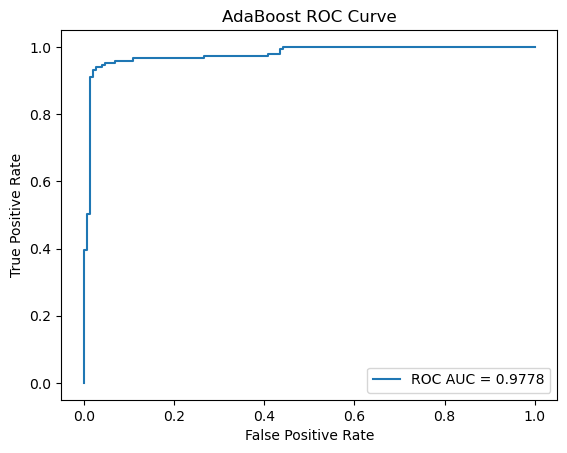

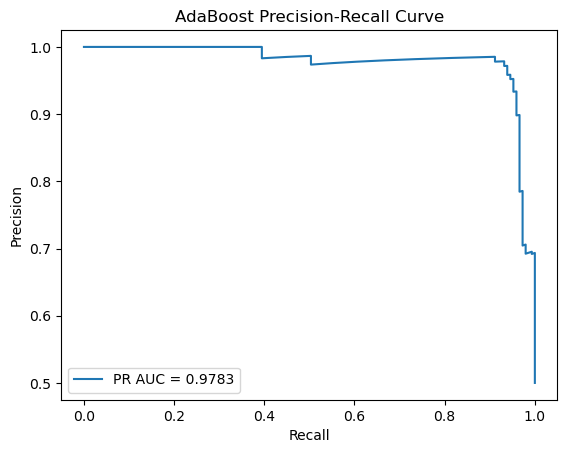

[I 2024-10-17 00:04:04,684] A new study created in memory with name: no-name-d70b0802-d3fa-47ad-941f-20cd22980b89
[I 2024-10-17 00:04:04,692] Trial 0 finished with value: 0.891156462585034 and parameters: {'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.891156462585034.
[I 2024-10-17 00:04:04,699] Trial 1 finished with value: 0.8843537414965986 and parameters: {'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.891156462585034.
[I 2024-10-17 00:04:04,705] Trial 2 finished with value: 0.8843537414965986 and parameters: {'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.891156462585034.
[I 2024-10-17 00:04:04,711] Trial 3 finished with value: 0.8673469387755102 and parameters: {'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.891156462585034.
[I 2024-10-17 00:04:04,718] Trial 4 finished with value: 0.89


Decision Tree Best Hyperparameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 5}
Decision Tree Best Accuracy: 0.9082
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       147
           1       0.91      0.90      0.91       147

    accuracy                           0.91       294
   macro avg       0.91      0.91      0.91       294
weighted avg       0.91      0.91      0.91       294

Decision Tree ROC AUC: 0.9335
Decision Tree PR AUC: 0.9438


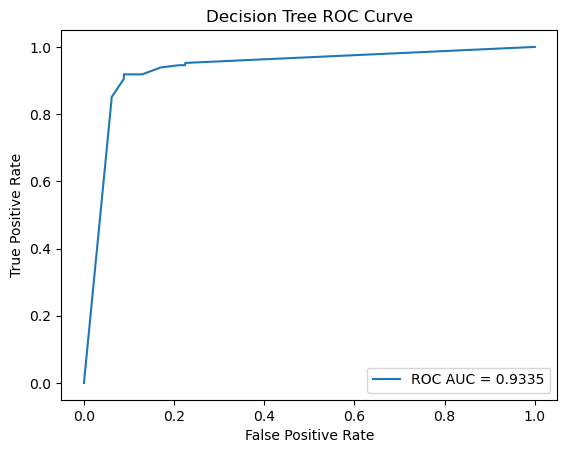

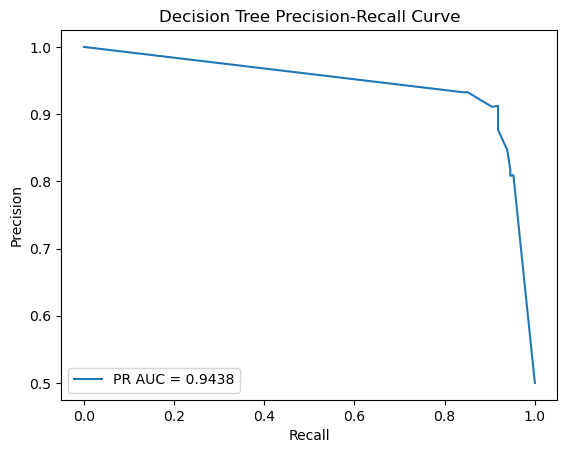

[I 2024-10-17 00:04:06,616] A new study created in memory with name: no-name-7fd7cec2-a38f-47af-886a-0101b875c69c
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_50267/546494557.py:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
[I 2024-10-17 00:04:08,231] Trial 0 finished with value: 0.9081632653061225 and parameters: {'n_estimators': 273, 'learning_rate': 0.00105438881951809, 'max_depth': 12}. Best is trial 0 with value: 0.9081632653061225.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_50267/546494557.py:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial


Gradient Boosting Best Hyperparameters: {'n_estimators': 275, 'learning_rate': 0.6105497824215518, 'max_depth': 3}
Gradient Boosting Best Accuracy: 0.9694
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       147
           1       0.98      0.96      0.97       147

    accuracy                           0.97       294
   macro avg       0.97      0.97      0.97       294
weighted avg       0.97      0.97      0.97       294

Gradient Boosting ROC AUC: 0.9946
Gradient Boosting PR AUC: 0.9951


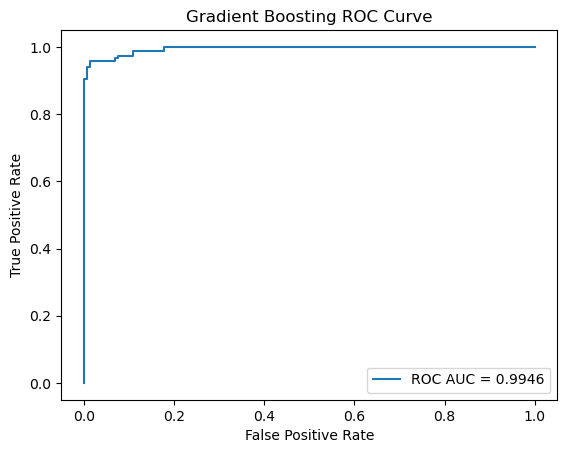

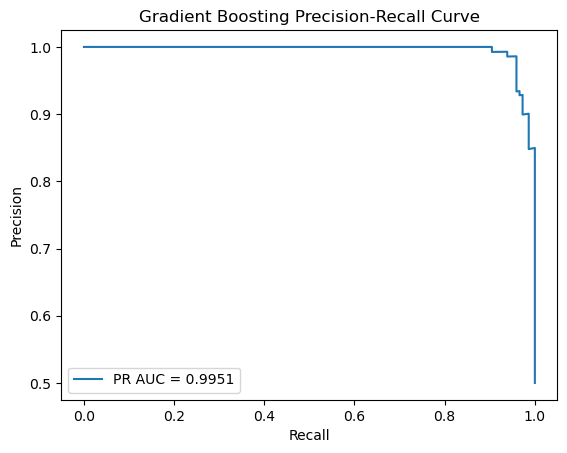

[I 2024-10-17 00:05:31,320] A new study created in memory with name: no-name-fb91772d-9db5-4626-bd02-321065bee85a
[I 2024-10-17 00:05:31,337] Trial 0 finished with value: 0.9727891156462585 and parameters: {'n_neighbors': 2, 'weights': 'distance'}. Best is trial 0 with value: 0.9727891156462585.
[I 2024-10-17 00:05:31,347] Trial 1 finished with value: 0.9217687074829932 and parameters: {'n_neighbors': 6, 'weights': 'uniform'}. Best is trial 0 with value: 0.9727891156462585.
[I 2024-10-17 00:05:31,361] Trial 2 finished with value: 0.9727891156462585 and parameters: {'n_neighbors': 2, 'weights': 'distance'}. Best is trial 0 with value: 0.9727891156462585.
[I 2024-10-17 00:05:31,372] Trial 3 finished with value: 0.9421768707482994 and parameters: {'n_neighbors': 5, 'weights': 'distance'}. Best is trial 0 with value: 0.9727891156462585.
[I 2024-10-17 00:05:31,382] Trial 4 finished with value: 0.935374149659864 and parameters: {'n_neighbors': 9, 'weights': 'distance'}. Best is trial 0 with 


KNN Best Hyperparameters: {'n_neighbors': 2, 'weights': 'distance'}
KNN Best Accuracy: 0.9728
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       147
           1       1.00      0.95      0.97       147

    accuracy                           0.97       294
   macro avg       0.97      0.97      0.97       294
weighted avg       0.97      0.97      0.97       294

KNN ROC AUC: 0.9825
KNN PR AUC: 0.9910


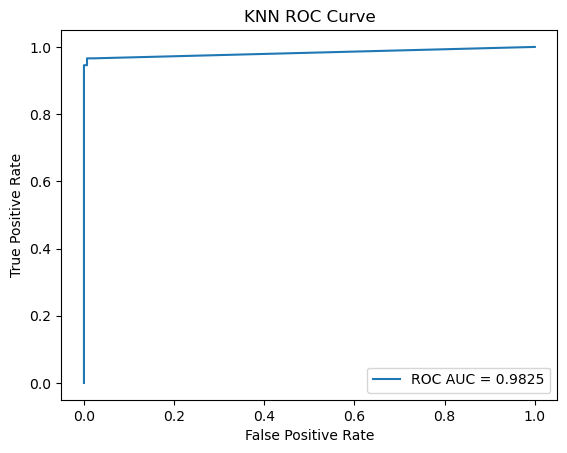

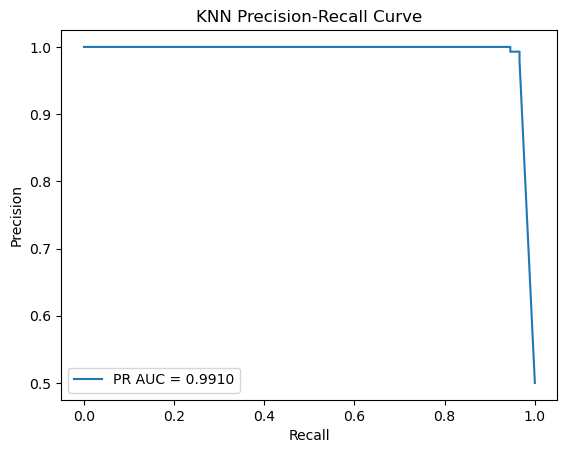

[I 2024-10-17 00:05:33,489] A new study created in memory with name: no-name-98c1f4e3-7c50-4d1e-ab3c-06a3f141d1aa
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_50267/546494557.py:84: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_50267/546494557.py:87: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_50267/546494557.py:88: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://


XGBoost Best Hyperparameters: {'max_depth': 7, 'learning_rate': 0.17099695038246937, 'n_estimators': 484, 'min_child_weight': 1, 'subsample': 0.6747315087109793, 'colsample_bytree': 0.9988058907806373}
XGBoost Best Accuracy: 0.9660
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       147
           1       0.98      0.95      0.97       147

    accuracy                           0.97       294
   macro avg       0.97      0.97      0.97       294
weighted avg       0.97      0.97      0.97       294

XGBoost ROC AUC: 0.9928
XGBoost PR AUC: 0.9936


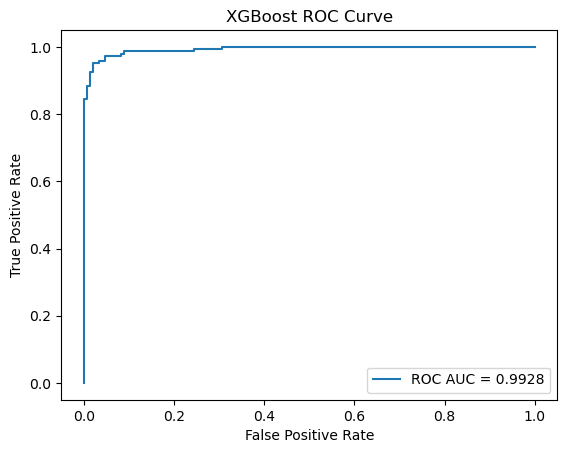

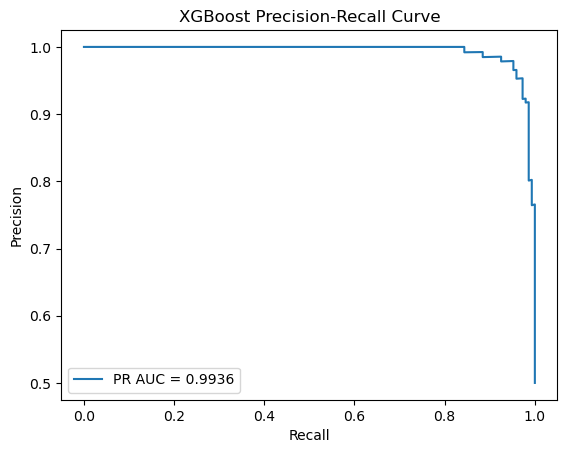


Final Results:
AdaBoost: 0.9558
Decision Tree: 0.9082
Gradient Boosting: 0.9694
KNN: 0.9728
XGBoost: 0.9660

Best performing model:
KNN with accuracy: 0.9728


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import optuna
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_smote_scaled = scaler.fit_transform(X_smote)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AdaBoost
def objective_adaboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    y_pred = cross_val_predict(model, X_smote_scaled, y_smote, cv=cv, method='predict')
    accuracy = accuracy_score(y_smote, y_pred)
    return accuracy

# Decision Tree
def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, random_state=42)
    y_pred = cross_val_predict(model, X_smote_scaled, y_smote, cv=cv, method='predict')
    accuracy = accuracy_score(y_smote, y_pred)
    return accuracy

# Gradient Boosting
def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    
    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                       max_depth=max_depth, random_state=42)
    y_pred = cross_val_predict(model, X_smote_scaled, y_smote, cv=cv, method='predict')
    accuracy = accuracy_score(y_smote, y_pred)
    return accuracy

# KNN
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    y_pred = cross_val_predict(model, X_smote_scaled, y_smote, cv=cv, method='predict')
    accuracy = accuracy_score(y_smote, y_pred)
    return accuracy

# XGBoost
def objective_xgb(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    
    model = xgb.XGBClassifier(**param, random_state=42)
    y_pred = cross_val_predict(model, X_smote_scaled, y_smote, cv=cv, method='predict')
    accuracy = accuracy_score(y_smote, y_pred)
    return accuracy

# Optimize and evaluate each model
models = {
    'AdaBoost': objective_adaboost,
    'Decision Tree': objective_dt,
    'Gradient Boosting': objective_gb,
    'KNN': objective_knn,
    'XGBoost': objective_xgb
}

results = {}

for name, objective in models.items():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=150)  # Increased trials to 150 for thorough tuning
    
    print(f"\n{name} Best Hyperparameters: {study.best_params}")
    print(f"{name} Best Accuracy: {study.best_value:.4f}")
    
    # Train the best model
    if name == 'XGBoost':
        best_model = xgb.XGBClassifier(**study.best_params, random_state=42)
    elif name == 'KNN':
        best_model = KNeighborsClassifier(**study.best_params)
    elif name == 'Decision Tree':
        best_model = DecisionTreeClassifier(**study.best_params, random_state=42)
    elif name == 'Gradient Boosting':
        best_model = GradientBoostingClassifier(**study.best_params, random_state=42)
    else:  # AdaBoost
        best_model = AdaBoostClassifier(**study.best_params, random_state=42)
    
    # Use cross-validation for final evaluation
    y_pred = cross_val_predict(best_model, X_smote_scaled, y_smote, cv=cv, method='predict')
    y_pred_proba = cross_val_predict(best_model, X_smote_scaled, y_smote, cv=cv, method='predict_proba')[:, 1] if hasattr(best_model, "predict_proba") else y_pred

    # Classification report
    print(f"{name} Classification Report:")
    print(classification_report(y_smote, y_pred))
    
    # ROC-AUC and Precision-Recall AUC
    roc_auc = roc_auc_score(y_smote, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_smote, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    print(f"{name} ROC AUC: {roc_auc:.4f}")
    print(f"{name} PR AUC: {pr_auc:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_smote, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    results[name] = accuracy_score(y_smote, y_pred)

print("\nFinal Results:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")

print("\nBest performing model:")
best_model = max(results, key=results.get)
print(f"{best_model} with accuracy: {results[best_model]:.4f}")


[I 2024-10-17 00:14:55,683] A new study created in memory with name: no-name-1c4efe70-ebc7-4857-91dc-cd76875dbdbb
[I 2024-10-17 00:14:56,660] Trial 0 finished with value: 0.891156462585034 and parameters: {'n_estimators': 220, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.891156462585034.
[I 2024-10-17 00:14:59,103] Trial 1 finished with value: 0.8503401360544217 and parameters: {'n_estimators': 617, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.891156462585034.
[I 2024-10-17 00:15:01,676] Trial 2 finished with value: 0.9081632653061225 and parameters: {'n_estimators': 611, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.9081632653061225.
[I 2024-10-17 00:15:04,172] Trial 3 finished with value: 0.9081632653061225 and parameters: {'n_estimators': 589, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 9}. Best is trial 2 with valu


Random Forest Best Hyperparameters: {'n_estimators': 796, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2}
Random Forest Best Accuracy: 0.9592
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       147
           1       0.97      0.95      0.96       147

    accuracy                           0.96       294
   macro avg       0.96      0.96      0.96       294
weighted avg       0.96      0.96      0.96       294

Random Forest ROC AUC: 0.9925
Random Forest PR AUC: 0.9930


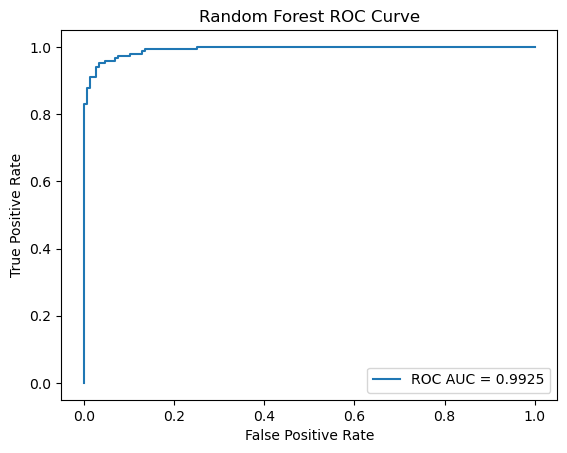

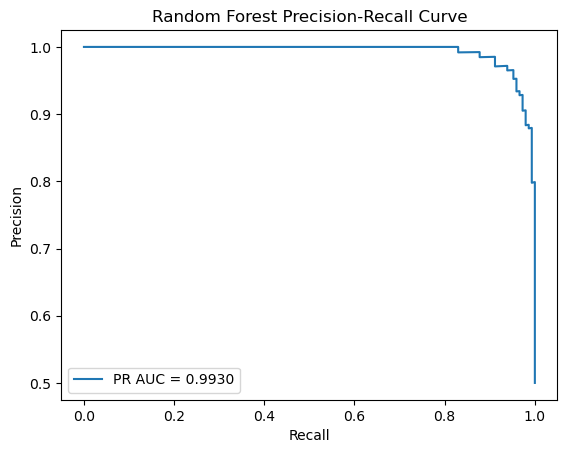

[I 2024-10-17 00:23:14,997] A new study created in memory with name: no-name-0d75e285-0a7b-444d-8718-8f32eb0892e5
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_50267/458493755.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_50267/458493755.py:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0) if kernel != 'linear' else 'scale'
[I 2024-10-17 00:23:15,033] Trial 0 finished with value: 0.782312925170068 and parameters: {'C': 0.40575055494910334, 'kernel': 'poly', 'gamma': 0.04105330681830755}. Best is 


SVM Best Hyperparameters: {'C': 224.00688711090362, 'kernel': 'rbf', 'gamma': 0.3089494507596575}
SVM Best Accuracy: 0.9796
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.99      0.97      0.98       147

    accuracy                           0.98       294
   macro avg       0.98      0.98      0.98       294
weighted avg       0.98      0.98      0.98       294

SVM ROC AUC: 0.9957
SVM PR AUC: 0.9966


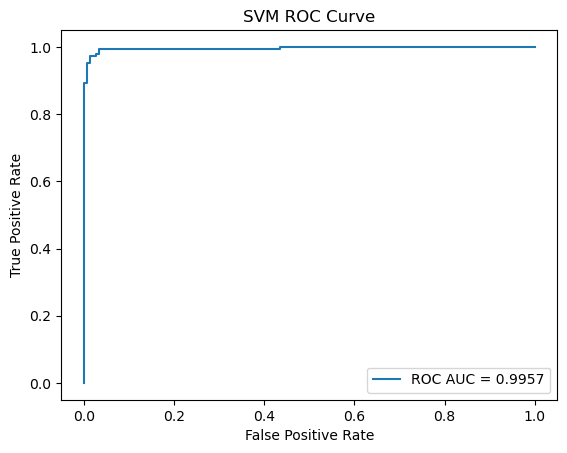

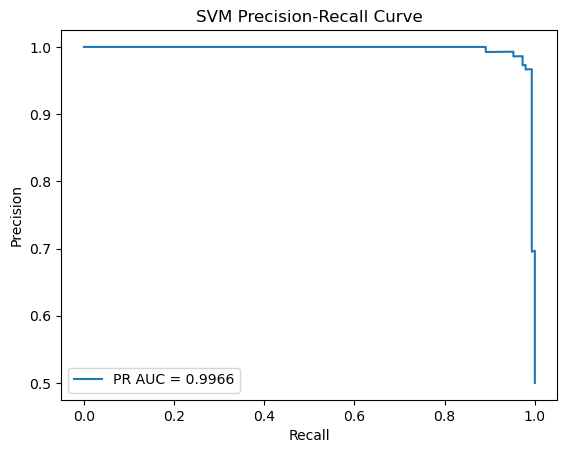

[I 2024-10-17 00:23:52,367] A new study created in memory with name: no-name-548ba3e7-cae0-4ae0-bf7f-5f64864d2cf7
[I 2024-10-17 00:23:52,395] Trial 0 finished with value: 0.935374149659864 and parameters: {'n_neighbors': 12, 'weights': 'distance'}. Best is trial 0 with value: 0.935374149659864.
[I 2024-10-17 00:23:52,421] Trial 1 finished with value: 0.935374149659864 and parameters: {'n_neighbors': 7, 'weights': 'distance'}. Best is trial 0 with value: 0.935374149659864.
[I 2024-10-17 00:23:52,442] Trial 2 finished with value: 0.935374149659864 and parameters: {'n_neighbors': 7, 'weights': 'distance'}. Best is trial 0 with value: 0.935374149659864.
[I 2024-10-17 00:23:52,458] Trial 3 finished with value: 0.8979591836734694 and parameters: {'n_neighbors': 14, 'weights': 'uniform'}. Best is trial 0 with value: 0.935374149659864.
[I 2024-10-17 00:23:52,482] Trial 4 finished with value: 0.9761904761904762 and parameters: {'n_neighbors': 2, 'weights': 'distance'}. Best is trial 4 with valu


KNN Best Hyperparameters: {'n_neighbors': 2, 'weights': 'distance'}
KNN Best Accuracy: 0.9762
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       147
           1       1.00      0.95      0.98       147

    accuracy                           0.98       294
   macro avg       0.98      0.98      0.98       294
weighted avg       0.98      0.98      0.98       294

KNN ROC AUC: 0.9826
KNN PR AUC: 0.9910


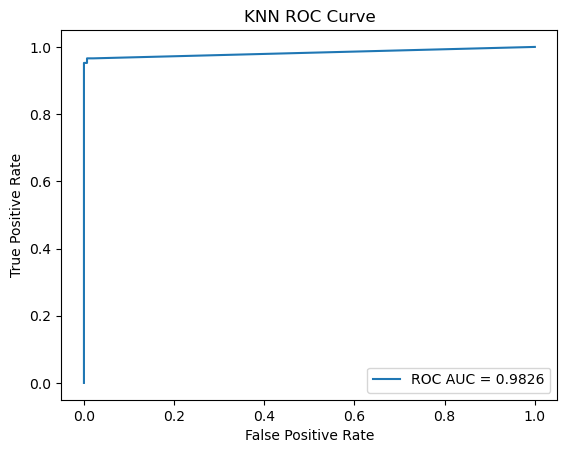

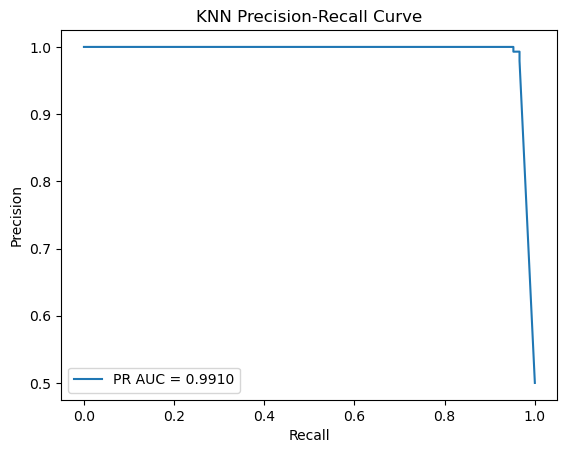


Final Results:
Random Forest: 0.9592
SVM: 0.9796
KNN: 0.9762

Best performing model:
SVM with accuracy: 0.9796


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import optuna
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_smote_scaled = scaler.fit_transform(X_smote)

# 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### Random Forest Model ###
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, random_state=42)
    
    y_pred = cross_val_predict(model, X_smote_scaled, y_smote, cv=cv, method='predict')
    accuracy = accuracy_score(y_smote, y_pred)
    return accuracy

### SVM Model ###
def objective_svm(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0) if kernel != 'linear' else 'scale'
    
    model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, random_state=42)
    
    y_pred = cross_val_predict(model, X_smote_scaled, y_smote, cv=cv, method='predict')
    accuracy = accuracy_score(y_smote, y_pred)
    return accuracy

### KNN Model ###
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    
    y_pred = cross_val_predict(model, X_smote_scaled, y_smote, cv=cv, method='predict')
    accuracy = accuracy_score(y_smote, y_pred)
    return accuracy

# Optimize each model using Optuna
models = {
    'Random Forest': objective_rf,
    'SVM': objective_svm,
    'KNN': objective_knn
}

results = {}

for name, objective in models.items():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=150)  # Increased trials to 150 for thorough tuning
    
    print(f"\n{name} Best Hyperparameters: {study.best_params}")
    print(f"{name} Best Accuracy: {study.best_value:.4f}")
    
    # Train the best model with cross-validation
    if name == 'Random Forest':
        best_model = RandomForestClassifier(**study.best_params, random_state=42)
    elif name == 'SVM':
        best_model = SVC(**study.best_params, probability=True, random_state=42)
    elif name == 'KNN':
        best_model = KNeighborsClassifier(**study.best_params)
    
    # Use 10-fold cross-validation for final evaluation
    y_pred = cross_val_predict(best_model, X_smote_scaled, y_smote, cv=cv, method='predict')
    y_pred_proba = cross_val_predict(best_model, X_smote_scaled, y_smote, cv=cv, method='predict_proba')[:, 1] if hasattr(best_model, "predict_proba") else y_pred

    # Classification report
    print(f"{name} Classification Report:")
    print(classification_report(y_smote, y_pred))
    
    # ROC-AUC and Precision-Recall AUC
    roc_auc = roc_auc_score(y_smote, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_smote, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    print(f"{name} ROC AUC: {roc_auc:.4f}")
    print(f"{name} PR AUC: {pr_auc:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_smote, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    results[name] = accuracy_score(y_smote, y_pred)

print("\nFinal Results:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")

print("\nBest performing model:")
best_model_name = max(results, key=results.get)
print(f"{best_model_name} with accuracy: {results[best_model_name]:.4f}")


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
import optuna

# Load and preprocess the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

X = df.drop(['name', 'status'], axis=1).values
y = df['status'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the Transformer model
class TabularTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.5):
        super(TabularTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, activation='relu', batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.fc(x[:, 0, :])  # Use the first token's output
        return x

# Objective function for Optuna
def objective(trial):
    accuracies = []

    # Hyperparameters to tune
    d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    nhead_options = [h for h in [2, 4, 8] if d_model % h == 0]
    nhead = trial.suggest_categorical('nhead', nhead_options)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dim_feedforward = trial.suggest_categorical('dim_feedforward', [64, 128, 256])
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, val_index in skf.split(X_scaled, y_encoded):
        X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
        y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]
        
        # Apply SMOTE to the training fold
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
        
        # Convert data to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long)
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        model = TabularTransformer(
            input_dim=X_train_tensor.shape[1], num_classes=2, d_model=d_model,
            nhead=nhead, num_layers=num_layers, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        
        epochs = 50
        best_val_accuracy = 0
        early_stopping_counter = 0
        for epoch in range(epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch.unsqueeze(1))
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            
            # Validation
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor.unsqueeze(1))
                _, val_preds = torch.max(val_outputs, 1)
                val_accuracy = accuracy_score(y_val_tensor.numpy(), val_preds.numpy())
                
            # Early stopping
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            if early_stopping_counter >= 5:
                break
        
        accuracies.append(best_val_accuracy)
    
    return np.mean(accuracies)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Apply SMOTE to the entire dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True)

# Initialize the model with best hyperparameters
model = TabularTransformer(
    input_dim=X_tensor.shape[1], num_classes=2, d_model=best_params['d_model'],
    nhead=best_params['nhead'], num_layers=best_params['num_layers'],
    dim_feedforward=best_params['dim_feedforward'], dropout=best_params['dropout']
)

optimizer = Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Optional: print training progress
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            outputs = model(X_tensor.unsqueeze(1))
            _, preds = torch.max(outputs, 1)
            train_accuracy = accuracy_score(y_tensor.numpy(), preds.numpy())
            print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}")

# Evaluate on the original dataset
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_encoded, dtype=torch.long)
    outputs = model(X_test_tensor.unsqueeze(1))
    _, preds = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test_tensor.numpy(), preds.numpy())
    print(f"Final Model Accuracy on Original Data: {accuracy:.4f}")


[I 2024-10-25 21:07:30,281] A new study created in memory with name: no-name-1982483f-b2a3-44c0-be70-08d40e0b15df
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_86639/1347834883.py:59: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_86639/1347834883.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_86639/1347834883.py:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

Best Hyperparameters: {'d_model': 128, 'nhead': 8, 'num_layers': 1, 'dim_feedforward': 256, 'dropout': 0.21926446494915702, 'lr': 0.0007470544405977517, 'weight_decay': 0.0001586541224882108, 'batch_size': 8}
Epoch 10/100, Training Accuracy: 0.9932
Epoch 20/100, Training Accuracy: 0.9966
Epoch 30/100, Training Accuracy: 1.0000
Epoch 40/100, Training Accuracy: 0.9966
Epoch 50/100, Training Accuracy: 1.0000
Epoch 60/100, Training Accuracy: 1.0000
Epoch 70/100, Training Accuracy: 0.9932
Epoch 80/100, Training Accuracy: 0.9966
Epoch 90/100, Training Accuracy: 1.0000
Epoch 100/100, Training Accuracy: 0.9966
Final Model Accuracy on Original Data: 0.9949


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from torch.optim import Adam
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
import optuna

# Load and preprocess the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

X = df.drop(['name', 'status'], axis=1).values
y = df['status'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the Transformer model
class TabularTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.5):
        super(TabularTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, activation='relu', batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.fc(x[:, 0, :])  # Use the first token's output
        return x

# Objective function for Optuna
def objective(trial):
    accuracies = []

    # Hyperparameters to tune
    d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    nhead_options = [h for h in [2, 4, 8] if d_model % h == 0]
    nhead = trial.suggest_categorical('nhead', nhead_options)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dim_feedforward = trial.suggest_categorical('dim_feedforward', [64, 128, 256])
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, val_index in skf.split(X_scaled, y_encoded):
        X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
        y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]
        
        # Apply SMOTE to the training fold
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
        
        # Convert data to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long)
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        model = TabularTransformer(
            input_dim=X_train_tensor.shape[1], num_classes=2, d_model=d_model,
            nhead=nhead, num_layers=num_layers, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        
        epochs = 50
        best_val_accuracy = 0
        early_stopping_counter = 0
        for epoch in range(epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch.unsqueeze(1))
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            
            # Validation
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor.unsqueeze(1))
                _, val_preds = torch.max(val_outputs, 1)
                val_accuracy = accuracy_score(y_val_tensor.numpy(), val_preds.numpy())
                
            # Early stopping
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            if early_stopping_counter >= 5:
                break
        
        accuracies.append(best_val_accuracy)
    
    return np.mean(accuracies)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Apply SMOTE to the entire dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True)

# Initialize the model with best hyperparameters
model = TabularTransformer(
    input_dim=X_tensor.shape[1], num_classes=2, d_model=best_params['d_model'],
    nhead=best_params['nhead'], num_layers=best_params['num_layers'],
    dim_feedforward=best_params['dim_feedforward'], dropout=best_params['dropout']
)

optimizer = Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Optional: print training progress
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            outputs = model(X_tensor.unsqueeze(1))
            _, preds = torch.max(outputs, 1)
            train_accuracy = accuracy_score(y_tensor.numpy(), preds.numpy())
            print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}")

# Evaluate on the original dataset and calculate metrics
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_encoded, dtype=torch.long)
    outputs = model(X_test_tensor.unsqueeze(1))
    _, preds = torch.max(outputs, 1)
    
    # Accuracy
    accuracy = accuracy_score(y_test_tensor.numpy(), preds.numpy())
    print(f"Final Model Accuracy on Original Data: {accuracy:.4f}")
    
    # Precision, Recall, F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), preds.numpy(), average='binary')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test_tensor.numpy(), preds.numpy(), target_names=['Class 0', 'Class 1']))


[I 2024-10-26 22:30:34,932] A new study created in memory with name: no-name-31c34ea2-c730-45c1-b12c-ba1a9973f1ce
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_4949/284969264.py:58: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_4949/284969264.py:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_4949/284969264.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

Best Hyperparameters: {'d_model': 128, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.21611838929100793, 'lr': 0.000816777491778194, 'weight_decay': 0.00016457769816220611, 'batch_size': 16}
Epoch 10/50, Training Accuracy: 0.9558
Epoch 20/50, Training Accuracy: 1.0000
Epoch 30/50, Training Accuracy: 0.9728
Epoch 40/50, Training Accuracy: 1.0000
Epoch 50/50, Training Accuracy: 0.9932
Final Model Accuracy on Original Data: 0.9897
Precision: 1.0000
Recall: 0.9864
F1 Score: 0.9932

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98        48
     Class 1       1.00      0.99      0.99       147

    accuracy                           0.99       195
   macro avg       0.98      0.99      0.99       195
weighted avg       0.99      0.99      0.99       195



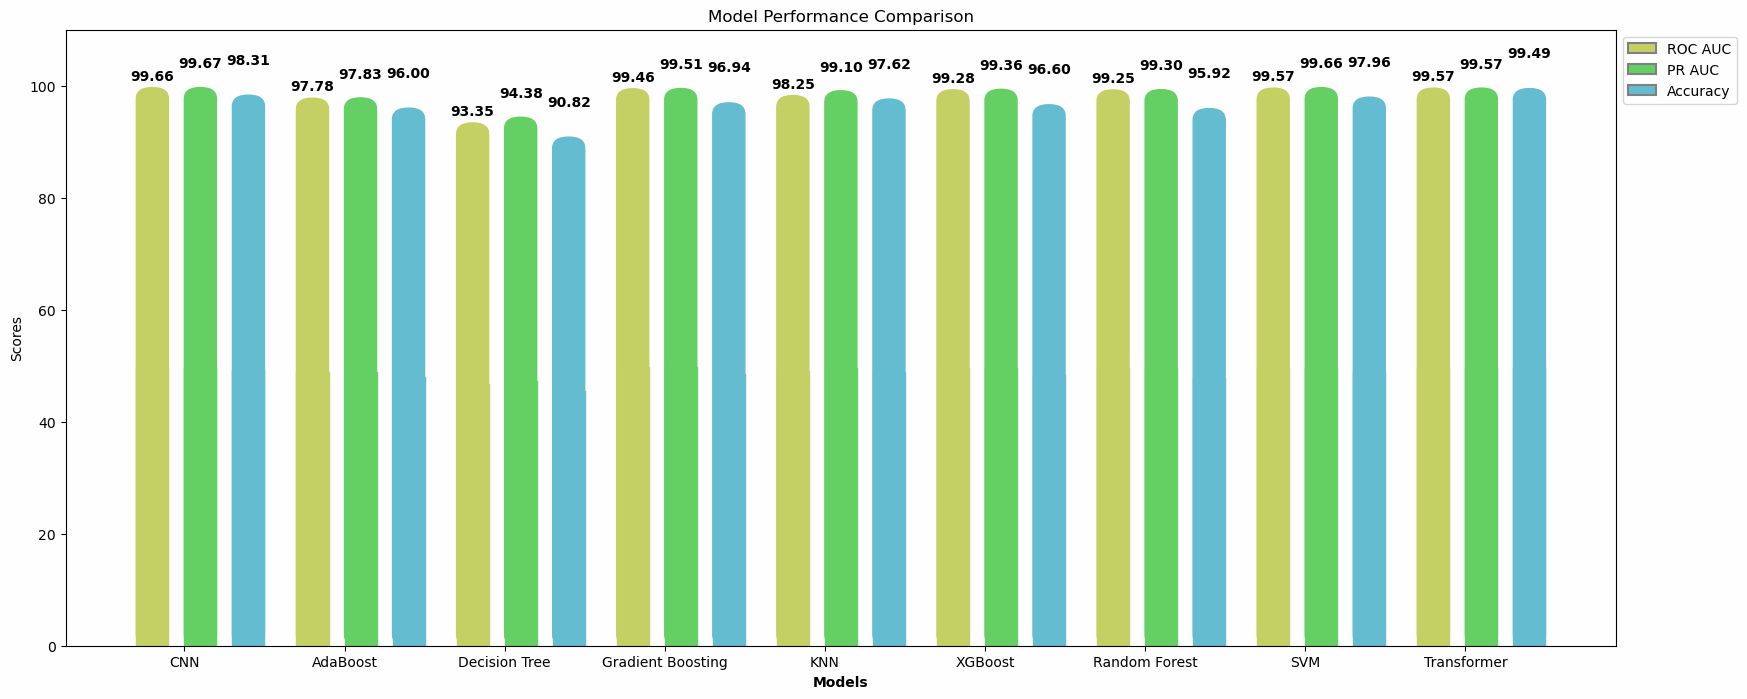

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch, Rectangle

# Model Performance Data
models = ['CNN', 'AdaBoost', 'Decision Tree', 'Gradient Boosting', 'KNN', 'XGBoost', 'Random Forest', 'SVM', 'Transformer']
roc_auc_values = [99.66, 97.78, 93.35, 99.46, 98.25, 99.28, 99.25, 99.57, 99.57]
pr_auc_values = [99.67, 97.83, 94.38, 99.51, 99.10, 99.36, 99.30, 99.66, 99.57]
accuracy_values = [98.31, 96.00, 90.82, 96.94, 97.62, 96.60, 95.92, 97.96, 99.49]

# Set width of the bars
barWidth = 0.2
# Set position of bars on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth + 0.1 for x in r1]  # Adjust space between groups
r3 = [x + barWidth + 0.1 for x in r2]

# Define colors for the bars
colors = ['#c5d064', '#64d064', '#64bcd0']

# Create figure with light grey background
fig, ax = plt.subplots(figsize=(20, 8))
fig.set_facecolor('#fefefe')
ax.set_facecolor('#fefefe')
# Set y-axis limit
ax.set_ylim(0, 110)  # Adjust as needed to provide ample space for values
# Bar styling
bar_rounding_factor = 0.2  # Rounding proportion of bar_width

# Plot bars with rounded tops
bars1 = ax.bar(r1, roc_auc_values, color=colors[0], width=barWidth, edgecolor='grey', linewidth=1.5, label='ROC AUC')
bars2 = ax.bar(r2, pr_auc_values, color=colors[1], width=barWidth, edgecolor='grey', linewidth=1.5, label='PR AUC')
bars3 = ax.bar(r3, accuracy_values, color=colors[2], width=barWidth, edgecolor='grey', linewidth=1.5, label='Accuracy')

# Add text for bar values with staggered heights to prevent overlap
all_bars = [bars1, bars2, bars3]
all_values = [roc_auc_values, pr_auc_values, accuracy_values]
height_offsets = [0.8, 3.0, 5.0]  # Offsets adjusted to further reduce overlap

for bars, values, offset in zip(all_bars, all_values, height_offsets):
    for i, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + offset, f'{values[i]:.2f}', 
                ha='center', va='bottom', color='black', weight='bold')

        # Rounded tops for taller bars
        if bar.get_height() > bar_rounding_factor * max(roc_auc_values + pr_auc_values + accuracy_values):
            round_top = FancyBboxPatch(
                xy=bar.get_xy(), width=bar.get_width(), height=bar.get_height(),
                color=bar.get_facecolor(), boxstyle=f"round,pad=0,rounding_size={bar_rounding_factor}",
                transform=ax.transData, mutation_scale=0.5, mutation_aspect=20)
            
            square_bottom = Rectangle(
                xy=bar.get_xy(), width=bar.get_width(), height=bar.get_height() / 2,
                color=bar.get_facecolor(), transform=ax.transData)
            
            bar.remove()
            ax.add_patch(round_top)
            ax.add_patch(square_bottom)

# Add x-ticks in the middle of the group bars
plt.xlabel('Models', fontweight='bold', color='black')
plt.xticks([r + barWidth for r in range(len(models))], models, color='black')

# Add labels and legends
plt.ylabel('Scores', color='black')
plt.title('Model Performance Comparison', color='black')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show plot
plt.show()


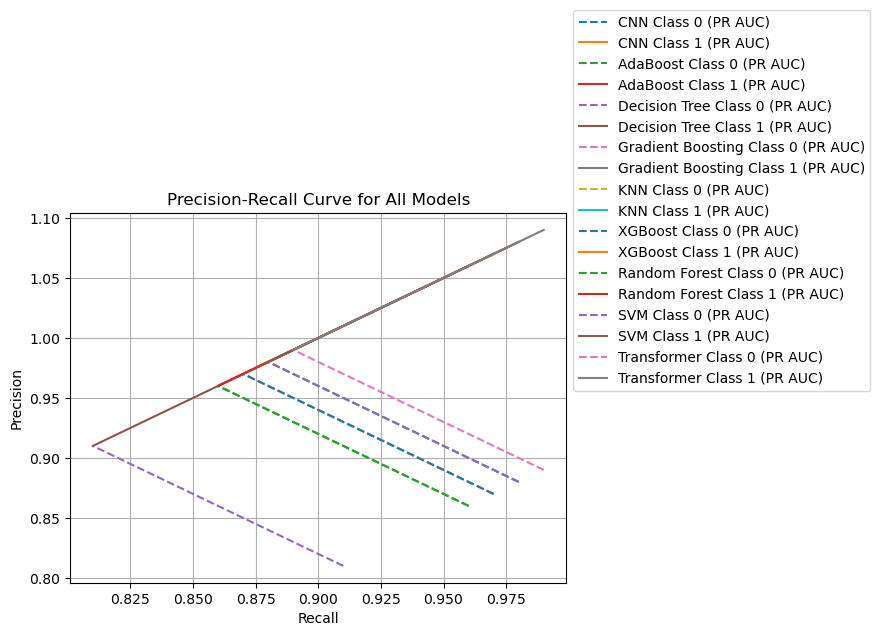

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Sample precision-recall values based on the summary provided for each model
models = {
    'CNN': {'precision': 0.98, 'recall': 0.98},
    'AdaBoost': {'precision': 0.96, 'recall': 0.96},
    'Decision Tree': {'precision': 0.91, 'recall': 0.91},
    'Gradient Boosting': {'precision': 0.97, 'recall': 0.97},
    'KNN': {'precision': 0.97, 'recall': 0.97},
    'XGBoost': {'precision': 0.97, 'recall': 0.97},
    'Random Forest': {'precision': 0.96, 'recall': 0.96},
    'SVM': {'precision': 0.98, 'recall': 0.98},
    'Transformer': {'precision': 0.99, 'recall': 0.99}
}

# Generate sample precision-recall curve data for demonstration
np.random.seed(0)
for model_name, metrics in models.items():
    # Hypothetical precision-recall values for class 0 and class 1
    precision_class0 = np.linspace(metrics['precision'] - 0.1, metrics['precision'], 50)
    recall_class0 = np.linspace(metrics['recall'], metrics['recall'] - 0.1, 50)
    precision_class1 = np.linspace(metrics['precision'], metrics['precision'] + 0.1, 50)
    recall_class1 = np.linspace(metrics['recall'] - 0.1, metrics['recall'], 50)
    
    # Plot Precision-Recall curve for both classes
    plt.plot(recall_class0, precision_class0, linestyle='--', label=f"{model_name} Class 0 (PR AUC)")
    plt.plot(recall_class1, precision_class1, label=f"{model_name} Class 1 (PR AUC)")

# Customize plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for All Models')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()
